# Inaugural Project

Imports and set magics:

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy import optimize
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import inauguralproject

# Question 1

In [7]:
# code for solving the model (remember documentation and comments) This is fine
# Using condition (2) on equation(1) we define the utility function of the consumer:
def utility(w, l, m = 1, v = 10, epsilon = 0.3, tau0 = 0.4, tau1 = 0.1, kappa = 0.4):
    tax = tau0*w*l+tau1*np.fmax(w*l-kappa,0)
    c = m+w*l-tax
    utility = np.log(c)-v*l**(1+1/epsilon)/(1+1/epsilon)
    return utility,c, tax

In [15]:
# Then we create a function to maximize the utility for given parameters:
def solveconsumerproblem(w, m = 1, v = 10, epsilon = 0.3, tau0 = 0.4, tau1 = 0.1, kappa = 0.4,\
                         N=100, callableoutput=False, tax=False):

    "Solves the consumerproblem for given parameters. If callableoutput is True the output is a tuple   with callable values, else the output is a neatly formatted string. If Tax is true, the consumers tax payment will be included in the output."

# We start by creating empty lists to store the output in. We use local lists to avoid changing the contents of the lists, since we have to run this function several times during the project.
    c_star = [0]
    l_star = [0]
    t_star = [0]
    utility_star = [-np.inf]

# We createde a range for L, called "Range" and check the utility for each element in said range. When we get a better utility, than the previous best value, we save the values of utility, labour, consumption and tax.    
    Range = np.linspace(0, 1, N)
    for i in Range:
        utility_temp = utility(l = i, w = w, epsilon = epsilon, tau0 = tau0, tau1 = tau1, kappa = kappa)
        if utility_temp[0]>utility_star:
            utility_star[0]=utility_temp[0]
            l_star[0] = i
            c_star[0] = utility_temp[1]
            t_star[0] = utility_temp[2]

# these are the conditionals for, if tax should be displayed and if not, should the output be a formatted string or a tuple with callable values.
    if tax == False:
        if callableoutput == False:
            print(f"The optimal labour and consumption (l*,C*) = ({l_star[0]:.3}, {c_star[0]:.3}) -> u(C*,l*) = {utility_star[0]:.3}")  
        else:
            return utility_star[0], l_star[0], c_star[0]
    
    if tax == True:
            return utility_star[0], l_star[0], c_star[0], t_star[0]

In [16]:
solveconsumerproblem(w=0.6, tax=False, callableoutput=False)

The optimal labour and consumption (l*,C*) = (0.354, 1.13) -> u(C*,l*) = 0.0943


# Question 2

In [17]:
# We start by generating lists of $l^*$ and $c^*$, containing the optimal values of l and c, for a given w.

w_range = np.linspace(0.5, 1.5, 200) # We define a range of w

# We create the empty lists for the output
l_list = []
c_list = []

# Then we loop through the w_range and save the optimal values of c and l
for i in w_range:
    l_list.append(solveconsumerproblem(w = i, callableoutput=True)[1])
    c_list.append(solveconsumerproblem(w = i, callableoutput=True)[2])

Text(0, 0.5, 'consumption')

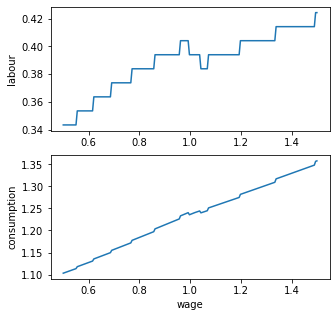

In [18]:
# We create the figure, not much else to say about it
fig = plt.figure(figsize=(5,5))

# sub figure 1
ax = fig.add_subplot(2,1,1)
plt.plot(w_range,l_list)
ax.set_ylabel("labour")

# sub figure 2
ax = fig.add_subplot(2,1,2)
ax.plot(w_range, c_list)
ax.set_xlabel('wage')
ax.set_ylabel('consumption')

# Question 3

In [21]:
# We start by generating the different wages for the different consumers

np.random.seed(seed = 1337)
wage_list = np.random.uniform(low = 0.5, high = 1.5, size = 10000)

In [22]:
def taxrev(wages, tau0, tau1, kappa, epsilon = 0.3):
    "Calculates the total tax revenu for a list of wages and given parameters"

# We generate an empty list to store output
    tax_payments = []

# Then we loop through the argument wages, for given other parameters and add the individual tax,  element [-1] in the solveconsumerproblem function, to the list tax_payments.
    for i in wages:
       tax_payments.append(solveconsumerproblem(w = i, tau0=tau0, tau1=tau1, epsilon=epsilon, \
       kappa=kappa, callableoutput = True, tax = True)[-1]) 
    
# Then we take the sum of all the individual taxes to get the total tax revenue.
    return np.sum(tax_payments)

In [23]:
# Then we call the taxrev function
print("The total tax revenue is " + \
str(round(taxrev(wages = wage_list, tau0=0.4, tau1=0.1, kappa=0.4, epsilon=0.3),2)))

The total tax revenue is 1633.53


# Question 4

In [36]:
# Now we run the taxrev function for epsilon=0.1
print("The total tax revenue, for epsilon = 0.1 is " + \
str(round(taxrev(wages = wage_list, tau0=0.4, tau1=0.1, kappa=0.4, epsilon=0.1),2)))

The total tax revenue, for epsilon = 0.1 is 3204.49


# Question 5

In [37]:
def negtaxrev(paraVec, wages = wage_list):
     'Returns the negative value of tax revenue'
    
    # We use a vector of the parameters to find the taxrev and multiply it by -1, so we can use a              minimizer.
     tau0 = paraVec[0]
     tau1 = paraVec[1]
     kappa = paraVec[2]
     temptaxrev = -1*taxrev(wages = wages, tau0 = tau0, tau1= tau1, kappa=kappa)

     # Band-aid solution to ensure kappa, the top tax cut-off, is non-negative.
     if kappa < 0:
          return 1
     else:
          return temptaxrev

In [38]:
initial_guess = [0.1, 0.1, 0.1]

# We use the scipy function, optimize.minimize to minimize negtaxrev. We use the Powell method, because some of the other methods didn't work or took suspiciously long time to run. Furthermore, since it isn't clearly specified wheter we should use epsilon = 0.1 or 0.3 in this question, we have chosen to use epsilon = 0.3.
sol_taxrev = optimize.minimize(negtaxrev, initial_guess, method = 'Powell')

In [40]:
print('Taxrex = ' + str(round(-sol_taxrev['fun'],3)))
print('Tau0 = '+ str(round(sol_taxrev['x'][0],3)) + ' Tau1 = '+ str(round(sol_taxrev['x'][1],3)) + \
' Kappa = '+ str((sol_taxrev['x'][2])))

Taxrex = 2471.397
Tau0 = 0.745 Tau1 = 0.03 Kappa = 1.0611637167009445e-07


# Conclusion

Using the optimizer, we would recommend having the top tax cut-off at almost 0, to be more precise; optimal kappa = 1.0611e-07. Furthermore, we would recommend having a rather low top income tax of 0.03, whereas the general income tax should be at aproximately 74,5%. This would result in an expected tax revenue of 2471.4 (whatever unit this is in), compared to the 1633.3 we had in question 3. It also deserves to be mentioned, that  the income tax of about 74,5%, is rather close to the estimated top of the laffer-curve for the US.